# Normalisation d'un essai
Le sujet de TP demande de comparer 2 mouvements réalisés sur une même tâche :
- entre deux individus 
- entre deux conditions expérimentales pour un même individu

Pour comparer ce qui est comparable, il est impératif de déterminer des critères cinématiques pour segmenter le début et la fin des mouvements étudiés.
Par exemple, si l'on souhaite comparer 2 sauts verticaux avec une rotation à 360° vers la gauche et vers la droite, nous pouvons segmenter les sauts de cette manière :
- Le marqueur de l'orteil s'éloigne du sol : 
    - distance par rapport au sol > à une distance seuil
    - vitesse verticale > à une vitesse seuil
- Le marqueur de l'orteil se rapproche du sol :
    - distance par rapport au sol < à une distance seuil
    
Si on souhaite comparer graphiquement des déplacements, nous pouvons également **recentrer** les trajectoires par rapport à un nouveau repère. De plus, si on compare des individus avec des morphologies différentes, nous pouvons normaliser spatialement les trajectoires par rapport à une valeur de référence. 

Enfin, nous pouvons **normaliser** les essais sur l'échelle temporelle pour faciliter la comparaison de différentes phases du mouvement.


## Démonstration sur un saut vertical avec une rotation vers la gauche et vers la droite

Sur ce mouvement réalisé dans les deux conditions, nous voulons comparer 2 variables cinématiques :
- La trajet du pelvis sur l'axe vertical. Quelles influences de la condition sur la phase de flexion et sur la hauteur max de saut ?
- Le trajet du pelvis sur le plan formé par l'axe antéro-postérieur et médio latéral. Quelle influence de la condition sur l'écart entre la position final et de départ ? (on pourrait prendre le déplacement du CoM pour être plus précis, mais nous simplifierons avec le centre des 4 marqueurs du pelvis pour gagner du temps dans ce TP). 


### Import des packages et des données

In [1]:
import numpy as np
from pyomeca import Markers
import matplotlib.pyplot as plt

file_path_360G = 'data/360_G.c3d' 
file_path_360D = 'data/360_D.c3d' 
markers_360G = Markers.from_c3d(file_path_360G)
markers_360D = Markers.from_c3d(file_path_360D)

### Filtrage des captures

In [2]:
freq_cutoff= 10
markers_360G_filt = markers_360G.meca.low_pass(order=2, cutoff=freq_cutoff,freq=markers_360G.attrs['rate'])
markers_360D_filt = markers_360D.meca.low_pass(order=2, cutoff=freq_cutoff,freq=markers_360D.attrs['rate'])

### Premières illustrations graphiques 

In [3]:
hip_markers_G = markers_360G_filt.sel(channel=['RFWT','RBWT','LFWT','LBWT'],axis=['x','y','z'])
hip_markers_D = markers_360D_filt.sel(channel=['RFWT','RBWT','LFWT','LBWT'],axis=['x','y','z'])

In [4]:
mean_hip_G = np.mean(hip_markers_G,axis=1).T
mean_hip_D = np.mean(hip_markers_D,axis=1).T

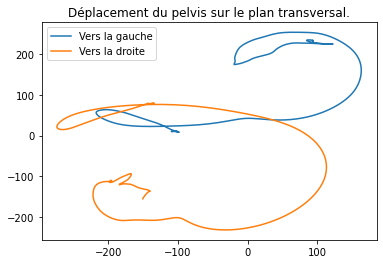

In [5]:
plt.plot(mean_hip_G[:,0],mean_hip_G[:,1],label='Vers la gauche')
plt.plot(mean_hip_D[:,0],mean_hip_D[:,1], label='Vers la droite')
plt.title("Déplacement du pelvis sur le plan transversal.")
plt.legend()
plt.show()

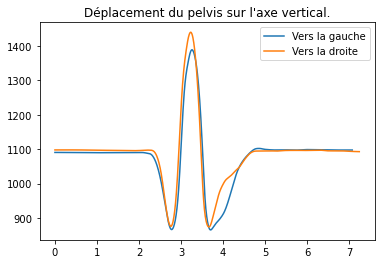

In [6]:
plt.plot(mean_hip_G.time,mean_hip_G[:,2],label='Vers la gauche')
plt.plot(mean_hip_D.time,mean_hip_D[:,2],label="Vers la droite")
plt.title("Déplacement du pelvis sur l'axe vertical.")
plt.legend()
plt.show()

Pour comparer le profil de déplacement du pelvis sur l'axe vertical, nous voulons déterminer les moments de début et de fin du mouvement :
- début de la flexion : vitesse du pelvis non nulle
- atterissage : vitesse minimale

### Séquençage du mouvement

#### Déterminer l'instant initial : Détecter la première variation de vitesse importante

In [7]:
# Calcule de la vitesse du pelvis

velocity_g = np.diff(mean_hip_G[:,2])/(1/150)
velocity_d = np.diff(mean_hip_D[:,2])/(1/150)

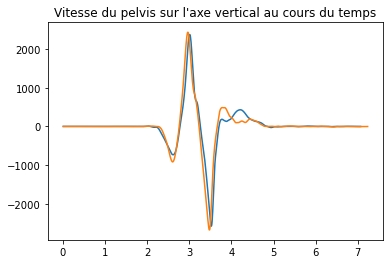

In [8]:

plt.plot(mean_hip_G.time[1:], velocity_g)
plt.plot(mean_hip_D.time[1:], velocity_d)
plt.title('Vitesse du pelvis sur l\'axe vertical au cours du temps')
plt.show()

En supposant que le premier mouvement fut une flexion (déplaçant le pelvis en direction du sol), nous pouvons simplement regarder la norme de vitesse et détecter la première valeure considérée comme non-nulle.
Comme valeur seuil, prenons 50 mm.s-1. Choix arbitraire ici, suffisamment bas pour détecter précisément le départ mais suffisamment haut pour s'épargner des oscillations parasites.

In [9]:
velocity_threshold = 50

velocity_g_norm = np.abs(np.diff(mean_hip_G[:,2])/(1/150))
velocity_d_norm = np.abs(np.diff(mean_hip_D[:,2])/(1/150))

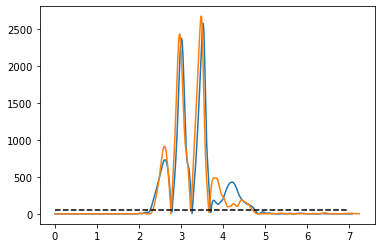

In [10]:


plt.plot(mean_hip_G.time[1:], velocity_g_norm)
plt.plot(mean_hip_D.time[1:], velocity_d_norm)
plt.plot([0,7],[velocity_threshold,velocity_threshold],c='black',linestyle='dashed')
plt.show()

Il faut maintenant trouver le premier instant où la valeur de vitesse sur l'axe vertical dépasse le seuil de vitesse.

In [11]:
first_index_g = np.argmax(velocity_g_norm > velocity_threshold)
first_index_d = np.argmax(velocity_g_norm > velocity_threshold)
print('Pour l\'essai vers la gauche, la flexion a démarré à ' + str(np.array(mean_hip_G.time)[first_index_g]) +'s.')

Pour l'essai vers la gauche, la flexion a démarré à 2.26s.


#### Déterminer le moment final

In [12]:
last_index_g = np.argmin(velocity_g)
last_index_d = np.argmin(velocity_d)
print('Pour l\'essai vers la gauche, la fin du saut se produit à ' + str(np.array(mean_hip_G.time)[last_index_g]) +'s.')
print('Pour l\'essai vers la droite, la fin du saut se produit à ' + str(np.array(mean_hip_D.time)[last_index_d]) +'s.')

Pour l'essai vers la gauche, la fin du saut se produit à 3.513333333333333s.
Pour l'essai vers la droite, la fin du saut se produit à 3.466666666666667s.


#### Recentrer le mouvement par rapport au début identifié

In [13]:
mean_hip_G_cut = mean_hip_G[first_index_g:last_index_g,:]
mean_hip_D_cut = mean_hip_D[first_index_d:last_index_d,:]
mean_hip_G_cut['cut_time'] = mean_hip_G_cut.time - mean_hip_G_cut.time[0]
mean_hip_D_cut['cut_time'] = mean_hip_D_cut.time - mean_hip_D_cut.time[0]

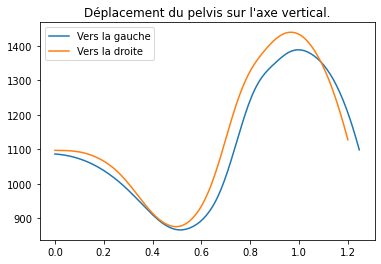

In [14]:
plt.plot(mean_hip_G_cut['cut_time'], mean_hip_G_cut[:,2],label='Vers la gauche')
plt.plot(mean_hip_D_cut['cut_time'], mean_hip_D_cut[:,2],label='Vers la droite')

plt.title("Déplacement du pelvis sur l'axe vertical.")
plt.legend()
plt.show()

Bien que la flexion semble avoir débutée plus tôt lors de la rotation vers la gauche, l'atterrissage se produit plus tard (écart minime). 
Même si l'atterrissage est plus tardif pour la rotation vers la gauche, cela n'est pas associé à une hauteur de saut plus importante.

In [15]:
impulse_frame_g = np.argmax(np.diff(mean_hip_G_cut[:,2])/(1/150))
impulse_frame_d = np.argmax(np.diff(mean_hip_D_cut[:,2])/(1/150))

imp_time_g = mean_hip_G_cut['cut_time'][impulse_frame_g]
imp_time_d = mean_hip_D_cut['cut_time'][impulse_frame_g]

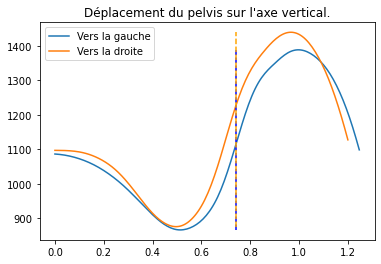

In [16]:
plt.plot(mean_hip_G_cut['cut_time'], mean_hip_G_cut[:,2],label='Vers la gauche')
plt.plot(mean_hip_D_cut['cut_time'], mean_hip_D_cut[:,2],label='Vers la droite')


plt.plot([imp_time_g,imp_time_g],[min(mean_hip_G_cut[:,2]),max(mean_hip_G_cut[:,2])],
          c='blue',linestyle='dashed')

plt.plot([imp_time_d,imp_time_d],[min(mean_hip_D_cut[:,2]),max(mean_hip_D_cut[:,2])],
          c='orange',linestyle='dashed')

plt.title("Déplacement du pelvis sur l'axe vertical.")
plt.legend()
plt.show()

Pour les deux conditions, la phase d'impulsion se produit quasiment au même moment (quelques frames d'écart). C'est la phase de vol qui a une durée plus courte dans la condition avec le saut vers la droite. 
:::{note}
Qu'est ce qui pourrait expliquer cela ?
:::

#### Recentrer la trajectoire du pelvis sur le plan transversale

In [17]:
mean_hip_g_x = np.array(mean_hip_G_cut[:,0] - mean_hip_G_cut[0,0])
mean_hip_g_y = np.array(mean_hip_G_cut[:,1] - mean_hip_G_cut[0,1])

mean_hip_d_x = np.array(mean_hip_D_cut[:,0] - mean_hip_D_cut[0,0])
mean_hip_d_y = np.array(mean_hip_D_cut[:,1] - mean_hip_D_cut[0,1])

In [18]:


plt.plot(mean_hip_g_x, mean_hip_g_y,label='Vers la gauche')
plt.plot(mean_hip_d_x, mean_hip_d_y, label='Vers la droite')
plt.scatter(0,0,c='red', s=50, label="Position initiale")
plt.scatter(mean_hip_g_x[impulse_frame_g],mean_hip_g_y[impulse_frame_g], c='blue', s=50, label='Impulsion')
plt.scatter(mean_hip_d_x[impulse_frame_d],mean_hip_d_y[impulse_frame_d], c='orange', s=50, label='Impulsion')

plt.title("Déplacement du pelvis sur le plan transversal.")
plt.legend()
plt.show()

Malgré l'instruction d'un saut exclusivement vertical, une dérive est constatée dans les deux conditions expérimentales. Potentiellement une dérive plus importante dans la condition avec un saut vers la droite.
On constate aussi un trajet plus long dans la phase de d'impulsion lors du saut vers la droite.

### Description de l'évolution de l'orientation du pelvis sur le plan transversal

#### Calcule de l'orientation comme l'angle entre la direction actuelle et la direction initiale

La direction du pelvis est définie ici comme le vecteur reliant le point proximal "centre du pelvis" et le point distal "avant du pelvis" (moyenne des épines iliaques supérieures antérieures).

In [19]:
iliac_g_markers = markers_360G_filt.sel(channel=['RFWT','LFWT'],axis=['x','y','z'])
front_pelvis_g = np.mean(iliac_g_markers,axis=1).T

iliac_d_markers = markers_360D_filt.sel(channel=['RFWT','LFWT'],axis=['x','y','z'])
front_pelvis_d = np.mean(iliac_d_markers,axis=1).T

In [20]:
pelvis_dir_g = np.array(front_pelvis_g[:,:2] - mean_hip_G[:,:2])
pelvis_dir_d = np.array(front_pelvis_d[:,:2] - mean_hip_D[:,:2])

In [21]:
pelvis_dir_initial_g = np.array(pelvis_dir_g[0,:])
pelvis_dir_initial_d = np.array(pelvis_dir_d[0,:])

In [22]:
def signed_angle(vector1, vector2):
    # Calculate the dot product of the two vectors
    dot_product = np.dot(vector1, vector2)

    # Calculate the cross product of the two vectors
    cross_product = np.cross(vector1, vector2)

    # Calculate the angle using atan2
    angle = np.arctan2(cross_product, dot_product)

    # Convert the angle from radians to degrees
    angle_degrees = np.degrees(angle)
    
    

    return angle_degrees



In [23]:
pelvis_angle_g = signed_angle(pelvis_dir_g,pelvis_dir_initial_g)
pelvis_angle_d = signed_angle(pelvis_dir_d,pelvis_dir_initial_d)
pelvis_angle_g = pelvis_angle_g[first_index_g:last_index_g]
pelvis_angle_d = pelvis_angle_d[first_index_d:last_index_d]

In [24]:
plt.plot(pelvis_angle_g)
plt.plot(pelvis_angle_d)
plt.show()

Dans le calcule d'un angle 2D, problématique du passage après 180° ou -180°. Nous pouvons ajuster les valeurs pour faciliter l'interprétation graphique

In [25]:
pelvis_angle_g[(np.argmax(np.diff(pelvis_angle_g) > 300)+1):] -= 360
pelvis_angle_d[(np.argmax(np.diff(pelvis_angle_d) < -300)+1):] += 360

In [26]:
plt.plot(pelvis_angle_g *(-1),label='Rotation vers la gauche')
plt.plot(pelvis_angle_d, label='Rotation vers la droite')
plt.plot([0, 175],[360,360],c='red',linestyle='dashed')
plt.legend()
plt.show()

On remarque qu'aucune des deux rotations n'atteint les 360°.

#### Normaliser le temps entre 2 indicateurs temporels : Comparaison des 2 profils de rotation

In [27]:
# Gauche
norm_time_g = mean_hip_G_cut.time -mean_hip_G_cut.time[0]
norm_time_g /= norm_time_g[-1]*0.01

# Droite
norm_time_d = mean_hip_D_cut.time -mean_hip_D_cut.time[0]
norm_time_d /= norm_time_d[-1]*0.01

In [28]:
plt.plot(norm_time_g,pelvis_angle_g*(-1),label='Vers la gauche')
plt.plot(norm_time_d,pelvis_angle_d, label='Vers la droite')
plt.plot([norm_time_g[impulse_frame_g],norm_time_g[impulse_frame_g]],[0,320],c='blue',linestyle='dashed')
plt.plot([norm_time_d[impulse_frame_d],norm_time_d[impulse_frame_d]],[0,320],c='orange',linestyle='dashed')
plt.plot([0, 100],[360,360],c='red')
plt.xlabel("% du mouvement")
plt.ylabel("Rotation par rapport à l'orientation initiale (°)")
plt.legend()
plt.show()

On remarque un début de rotation dès la phase d'impulsion (à gauche de la ligne en pointillets) pour les deux conditions. On remarque une rotation plus rapide pour la condition de saut vers la droite.

:::{note}
Ensemble, hauteur de saut plus importante et vitesse de rotation plus importante dans la condition de saut vers la droite, qu'est ce que cela pourrait signifier ?
:::